In [1]:
from __future__ import print_function

import os, numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from typing import Type, Any, Callable, Union, List, Optional
from torch import Tensor
from collections import OrderedDict

import time
from tqdm import tqdm
import random

from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import math
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from itertools import product
from scripts.utilities.data_calculator import get_mean_st
# from scripts.customized_net.models import BasicBlock, WideResNet_v1, ResNet
from scripts.customized_net.nervous_system import brain
from scripts.utilities.train_val import train
from scripts.utilities.get_dataset import ImageNetDownSample

In [8]:
%%javascript
IPython.notebook.kernel.execute('book_name = "' + IPython.notebook.notebook_name+'"')

<IPython.core.display.Javascript object>

In [9]:
print(book_name)

experiment_id = int(book_name[book_name.rfind('seed')+4:len(book_name)-6:1]) # Experiment 1 - ResNet replicate
print("Experiment:",experiment_id)

ResNet50_deep_resnet_ziyuan-seed1.ipynb
Experiment: 1


In [4]:
# np seed max 2**32 - 1
# https://numpy.org/doc/stable/reference/random/legacy.html
seed_factor = ((2**32 - 1)/60)

def set_seeds(seed, experiment_id=None):
    if not seed:
        seed = 10
        
    seed = int(seed * experiment_id)

    print("[ Using Seed : ", seed, " ]")

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [5]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [14]:
num_workers = 0
valid_size = 0.1
batch_size = 128

train_transform = transforms.Compose([transforms.ToTensor(),])
valid_transform = transforms.Compose([transforms.ToTensor(),])
test_transform = transforms.Compose([transforms.ToTensor(),])

dir_path = 'data/Imagenet32_train'

train_data = ImageNetDownSample(dir_path, train=True, transform=train_transform)
valid_data = ImageNetDownSample(dir_path, train=True, transform=valid_transform)
test_data = ImageNetDownSample(dir_path, train=False, transform=test_transform)

set_seeds(seed_factor, experiment_id)
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler,
                          num_workers=num_workers, worker_init_fn=seed_worker)
valid_loader = DataLoader(valid_data, batch_size=batch_size, sampler=valid_sampler,
                          num_workers=num_workers, worker_init_fn=seed_worker)
test_loader  = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, 
                          worker_init_fn=seed_worker, shuffle=True)

In [15]:
# len(train_loader.sampler),len(valid_loader.sampler),len(test_loader.sampler)

In [16]:
# for i, (data, target) in enumerate(test_loader):
#     if i == 1: print(torch.min(data), torch.max(data))

In [18]:
# train_mean, train_std = get_mean_st(train_loader)
# valid_mean, valid_std = get_mean_st(valid_loader)
# test_mean, test_std = get_mean_st(test_loader)
# print(train_mean, train_std)
# print(valid_mean, valid_std)
# print(test_mean, test_std)

In [19]:
# tensor([0.4811, 0.4575, 0.4079]) tensor([0.2604, 0.2532, 0.2682])
# tensor([0.4813, 0.4575, 0.4077]) tensor([0.2607, 0.2534, 0.2682])
# tensor([0.4730, 0.4502, 0.4011]) tensor([0.2579, 0.2511, 0.2654])
train_mean, train_std = torch.tensor([0.4811, 0.4575, 0.4079]), torch.tensor([0.2604, 0.2532, 0.2682])
valid_mean, valid_std = torch.tensor([0.4813, 0.4575, 0.4077]), torch.tensor([0.2607, 0.2534, 0.2682])
test_mean, test_std   = torch.tensor([0.4730, 0.4502, 0.4011]), torch.tensor([0.2579, 0.2511, 0.2654])
print(train_mean, train_std)
print(valid_mean, valid_std)
print(test_mean, test_std)

tensor([0.4811, 0.4575, 0.4079]) tensor([0.2604, 0.2532, 0.2682])
tensor([0.4813, 0.4575, 0.4077]) tensor([0.2607, 0.2534, 0.2682])
tensor([0.4730, 0.4502, 0.4011]) tensor([0.2579, 0.2511, 0.2654])


In [20]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((32, 32)),
    transforms.RandomCrop((32, 32), padding = 4),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
])

valid_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(valid_mean, valid_std),
])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomCrop((32, 32), padding = 4),
    #transforms.RandomRotation(10),
    #transforms.ColorJitter(),
    #transforms.RandomAffine(10),
    transforms.ToTensor(),
    transforms.Normalize(test_mean, test_std),
])

In [21]:
num_workers = 0
valid_size = 0.1
batch_size = 128

dir_path = 'data/Imagenet32_train'

train_data = ImageNetDownSample(dir_path, train=True, transform=train_transform)
valid_data = ImageNetDownSample(dir_path, train=True, transform=valid_transform)
test_data = ImageNetDownSample(dir_path, train=False, transform=test_transform)

##################
#### set seed ####
##################
set_seeds(seed_factor, experiment_id)
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, 
                               num_workers=num_workers, worker_init_fn=seed_worker)
valid_loader = DataLoader(valid_data, batch_size=batch_size, sampler=valid_sampler, 
                               num_workers=num_workers, worker_init_fn=seed_worker)

test_loader  = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, worker_init_fn=seed_worker, shuffle=True)

classes, class_counts = np.unique(train_loader.dataset.train_labels, return_counts=True)
class_num = len(classes)
class_num

[ Using Seed :  143165576  ]


1000

In [22]:
for i, (data, target) in enumerate(test_loader):
    if i == 1: 
        print(data.shape)
        print(torch.min(data), torch.max(data))

torch.Size([128, 3, 32, 32])
tensor(-1.8340) tensor(2.2566)


[ Using Seed :  143165576  ]


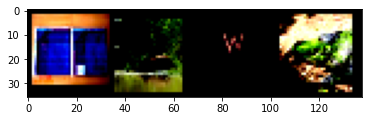

In [23]:
def imshow(img):
    #img = transforms.Normalize((-train_mean/train_std).tolist(),(1.0/train_std).tolist())(img)
    img = np.clip(img, 0, 1)
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

##################
#### set seed ####
##################
set_seeds(seed_factor, experiment_id)
image_iter = iter(train_loader)
images, _ = image_iter.next()
imshow(torchvision.utils.make_grid(images[:4]))

- 258458

In [12]:
# Nerve Cord 1 - Downsizing Images and Remaining Image Quality
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )

def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
    
class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

   
    
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        
        # self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        # self.bn1 = norm_layer(self.inplanes)
        # self.relu = nn.ReLU(inplace=True)
        # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.stemblock = nn.Sequential(OrderedDict([
            ("conv1",nn.Conv2d(3, self.inplanes, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)),
            ("bn1",norm_layer(self.inplanes)),
            ("relu",nn.ReLU(inplace=True)),
            #self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        ]))
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.stemblock(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

In [13]:
# layers = [50, 1001]
# n = int((layers[0] - 2) / 9)
# print("n:",n)
# print("Total layers:",9*n+2)

In [14]:
##################
#### set seed ####
##################
set_seeds(seed_factor, experiment_id)
deep_net = ResNet(Bottleneck, [3, 4, 6, 3])
#num_ftrs = deep_net.fc.in_features
#deep_net.fc = nn.Linear(num_ftrs, len(classes))
deep_net_total_params = sum(p.numel() for p in deep_net.parameters())
print("DeepNet parameters:",deep_net_total_params)

[ Using Seed :  71582788  ]
DeepNet parameters: 25549352


In [62]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(deep_net.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")

outputs = []
names = []
image = torch.randn(2, 64, 32, 32)
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print("Total ResNet layers:",len(outputs)+2)
#print feature_maps
for feature_map in outputs:
    #pass
    print(feature_map.shape)

Total convolution layers: 48
Total ResNet layers: 50
torch.Size([2, 64, 32, 32])
torch.Size([2, 64, 32, 32])
torch.Size([2, 256, 32, 32])
torch.Size([2, 64, 32, 32])
torch.Size([2, 64, 32, 32])
torch.Size([2, 256, 32, 32])
torch.Size([2, 64, 32, 32])
torch.Size([2, 64, 32, 32])
torch.Size([2, 256, 32, 32])
torch.Size([2, 128, 32, 32])
torch.Size([2, 128, 16, 16])
torch.Size([2, 512, 16, 16])
torch.Size([2, 128, 16, 16])
torch.Size([2, 128, 16, 16])
torch.Size([2, 512, 16, 16])
torch.Size([2, 128, 16, 16])
torch.Size([2, 128, 16, 16])
torch.Size([2, 512, 16, 16])
torch.Size([2, 128, 16, 16])
torch.Size([2, 128, 16, 16])
torch.Size([2, 512, 16, 16])
torch.Size([2, 256, 16, 16])
torch.Size([2, 256, 8, 8])
torch.Size([2, 1024, 8, 8])
torch.Size([2, 256, 8, 8])
torch.Size([2, 256, 8, 8])
torch.Size([2, 1024, 8, 8])
torch.Size([2, 256, 8, 8])
torch.Size([2, 256, 8, 8])
torch.Size([2, 1024, 8, 8])
torch.Size([2, 256, 8, 8])
torch.Size([2, 256, 8, 8])
torch.Size([2, 1024, 8, 8])
torch.Size([2,

In [63]:
l = 0
for i, j in enumerate(deep_net.state_dict()):
    if ('layer') in j:
        if ('conv') in j:
            l+=1 
            print("Conv Layer",l,"---",j.replace(".weight",""))

Conv Layer 1 --- layer1.0.conv1
Conv Layer 2 --- layer1.0.conv2
Conv Layer 3 --- layer1.0.conv3
Conv Layer 4 --- layer1.1.conv1
Conv Layer 5 --- layer1.1.conv2
Conv Layer 6 --- layer1.1.conv3
Conv Layer 7 --- layer1.2.conv1
Conv Layer 8 --- layer1.2.conv2
Conv Layer 9 --- layer1.2.conv3
Conv Layer 10 --- layer2.0.conv1
Conv Layer 11 --- layer2.0.conv2
Conv Layer 12 --- layer2.0.conv3
Conv Layer 13 --- layer2.1.conv1
Conv Layer 14 --- layer2.1.conv2
Conv Layer 15 --- layer2.1.conv3
Conv Layer 16 --- layer2.2.conv1
Conv Layer 17 --- layer2.2.conv2
Conv Layer 18 --- layer2.2.conv3
Conv Layer 19 --- layer2.3.conv1
Conv Layer 20 --- layer2.3.conv2
Conv Layer 21 --- layer2.3.conv3
Conv Layer 22 --- layer3.0.conv1
Conv Layer 23 --- layer3.0.conv2
Conv Layer 24 --- layer3.0.conv3
Conv Layer 25 --- layer3.1.conv1
Conv Layer 26 --- layer3.1.conv2
Conv Layer 27 --- layer3.1.conv3
Conv Layer 28 --- layer3.2.conv1
Conv Layer 29 --- layer3.2.conv2
Conv Layer 30 --- layer3.2.conv3
Conv Layer 31 --- l

from pprint import pprint
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(wide_net.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
pprint(conv_layers)

outputs = []
names = []
image = torch.randn(2, 16, 32, 32)
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

n = 0
for name, param in wide_net.named_parameters():
    if "conv" in name or "fc.w" in name or "fc1." in name:
        n+=1
        print(f"Layer {n}:",name, param.data.shape)

n = 0
for name, param in wide_net.named_parameters():
    if "conv" in name or "fc.w" in name or "fc1." in name:
        n+=1
        print(f"Layer {n}:",name, param.data.shape)

wide_net

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(wide_net)

In [64]:
deep_net

ResNet(
  (stemblock): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1

In [15]:
device_ids = [d for d in range(torch.cuda.device_count())]

device = f'cuda:{device_ids[0]}' if torch.cuda.is_available() else 'cpu'

deep_net = deep_net.to(device)

#if device == 'cuda:0':
#    deep_net = nn.DataParallel(deep_net, device_ids)
    
device

'cuda:0'

In [66]:
lr = 1e-1
momentum = 0.9
weight_decay = 5e-4 # 1e-4 # 5e-4

criterion = nn.CrossEntropyLoss()

##################
#### set seed ####
##################
#set_seeds(seed_factor, experiment_id)
deep_optimizer = optim.SGD(deep_net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay) # 1e-4
deep_scheduler = optim.lr_scheduler.CosineAnnealingLR(deep_optimizer, T_max=100, eta_min=0, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-01.


In [10]:
def net_name(model):
    if isinstance(model, nn.DataParallel):
        model_name = model.module.__class__.__name__
    else:
        model_name = model.__class__.__name__
    return model_name

In [11]:
nb_name = book_name
nb_name = os.path.splitext(nb_name.replace(" ","").replace("-","_").replace("%20","").lower())[0]
weights_path = 'pretrained/model_cifar_'+nb_name
deep_net_weights = weights_path+"_"+net_name(deep_net)+'.pt'
weights_path, deep_net_weights

NameError: name 'deep_net' is not defined

In [69]:
if os.path.exists(Path(weights_path).parent) == False:
    os.makedirs(Path(weights_path).parent)
else:
    print(Path(weights_path).parent, "exists")

load_model = ''
if load_model == "deep":
    checkpoint = torch.load(deep_net_weights)
    deep_net.load_state_dict(checkpoint['net'])
    start_epoch = checkpoint['epoch']
elif load_model == "wide":
    checkpoint = torch.load(wide_net_weights)
    deep_net.load_state_dict(checkpoint['net'])
    start_epoch = checkpoint['epoch']
else:
    start_epoch = 0
print('start_epoch: %s' % start_epoch)

pretrained exists
start_epoch: 0


In [70]:
net_name(deep_net)

'ResNet'

In [71]:
len(train_loader.sampler),len(valid_loader.sampler),len(test_loader.sampler)

(1153051, 128116, 50000)

In [72]:
1153051/128/300, 128116/128/100

(30.02736979166667, 10.0090625)

In [73]:
# Training
best_acc_cord1 = 0
best_acc_cord2 = 0
model_list = []

def net_name(model):
    if isinstance(model, nn.DataParallel):
        model_name = model.module.__class__.__name__
    else:
        model_name = model.__class__.__name__
    return model_name
        
def train(epoch, model, pre_trained_weights, train_loader, valid_loader, optimizer, criterion, scheduler, device):

    global best_acc_cord1, best_acc_cord2, model_list
    
    start_time = time.time()
    model_name = net_name(model)
    
    if model_name not in model_name:
        model_name.append(model_name)

    print(f'\nEpoch: {epoch+1} on {model_name}')

    criterion.to(device)
    model.to(device)

    model.train()
    
    if isinstance(model, nn.DataParallel):
        model_name = model.module.__class__.__name__
    else:
        model_name = model.__class__.__name__

    train_loss, train_loss_list = 0, []
    train_correct = 0
    train_total = 0
    train_acc = 0
    
    print("------Train------")
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_loss_list.append(loss.item())
        
        # print(outputs.max(1))
        # print(torch.max(outputs, 1))
        
        _, predicted = outputs.max(1) # _, preds = torch.max(outputs, 1)
        
        train_total += targets.size(0)
        train_correct += predicted.eq(targets).sum().item()
        
        # print(predicted.eq(targets).sum().item())
        # print((predicted == targets).sum().item())

        if batch_idx % 300 == 299:    # print every 30 mini-batches
            train_acc = train_correct/train_total
            print('[%d, %5d] Train Loss: %.6f |  Train Acc: %.3f%% (%d/%d)' %
                  (epoch + 1, batch_idx + 1, train_loss, 100.*train_acc, train_correct, train_total))
    
    # train_loss /= len(train_loader.sampler)

    train_acc = 100.*train_correct/train_total

    print('Epoch Train Loss: %.6f' % train_loss)
        
    model.eval()
    
    val_loss, valid_loss_list = 0, []
    val_correct = 0
    val_total = 0
    val_acc = 0
    
    print("------Validation------")
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valid_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            valid_loss_list.append(loss.item())
            
            # print(outputs.max(1))
            # print(torch.max(outputs, 1))

            _, predicted = outputs.max(1) # _, preds = torch.max(outputs, 1)

            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()

            # print(predicted.eq(targets).sum().item())
            # print((predicted == targets).sum().item())
            val_acc = val_correct/val_total
            if batch_idx % 100 == 99:    # print every 10 mini-batches
                print('[%d, %5d] Val Loss: %.6f |  Val Acc: %.3f%% (%d/%d)' %
                      (epoch + 1, batch_idx + 1, val_loss, 100.*val_acc, val_correct, val_total))
    
    print("\n")
    # val_loss /= len(valid_loader.sampler)
    val_acc = 100.*val_correct/val_total
    
    if model_name not in model_list:
        model_list.append(model_name)

    state = {
        'net': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch,
    }

    if len(model_list) == 1:
        print("Single-Model Mode")
        if val_acc > best_acc_cord1:
            if model_list.index(model_name) == 0:
                print(f'Validation accuracy have improved from {best_acc_cord1:.4f} to {val_acc:.4f},',
                      f'saving the new {model_list[0]} model...')
                best_acc_cord1 = val_acc
                torch.save(state, pre_trained_weights)
        print('Epoch Valid Loss: %.6f' % val_loss,
              f"| Best Global Accuracy {max(best_acc_cord1,best_acc_cord2):.4f}",
              f"| Best {model_list[0]} Accuracy {best_acc_cord1:.4f}")
    else:
        print("Multi-Model Mode")
        if val_acc > best_acc_cord1:
            if model_list.index(model_name) == 0:
                print(f'Validation accuracy have improved from {best_acc_cord1:.4f} to {val_acc:.4f},',
                      f'saving the new {model_list[0]} model...')
                best_acc_cord1 = val_acc
                torch.save(state, pre_trained_weights)
        print('Epoch Valid Loss: %.6f' % val_loss, 
              f"| Best Global Accuracy {max(best_acc_cord1,best_acc_cord2):.4f}",
              f"| Best {model_list[0]} Accuracy {best_acc_cord1:.4f}")
        if val_acc > best_acc_cord2:
            if model_list.index(model_name) == 1:
                print(f'Validation accuracy have improved from {best_acc_cord2:.4f} to {val_acc:.4f},',
                      f'saving the new {model_list[1]} model...')
                best_acc_cord2 = val_acc
                torch.save(state, pre_trained_weights)
        print('Epoch Valid Loss: %.6f' % val_loss, 
              f"| Best Global Accuracy {max(best_acc_cord1,best_acc_cord2):.4f}",
              f"| Best {model_list[1]} Accuracy {best_acc_cord2:.4f}")
                

    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed per Epoch: {elapsed:.2f} min')
    
    scheduler.step()

    return train_loss, train_acc, train_loss_list, val_loss, val_acc, valid_loss_list

In [ ]:
start_time = time.time()
start_epoch = 0
epochs = 100

exchange = 10 # network exchange threshold

aggregated_epoch = 0

deep_output, wide_output = [], []

for epoch in range(start_epoch, epochs):
    
    if epoch == 0: set_seeds(seed_factor, experiment_id)

    aggregated_epoch+=1
    print("\nAggregated Epoch:", aggregated_epoch)
    deep_output.append(train(epoch,deep_net,deep_net_weights,train_loader,valid_loader,deep_optimizer,criterion,deep_scheduler,device))

elapsed = (time.time() - start_time)/60
model_name = f"Wide ResNet20 Seed {experiment_id}"
print(f'Individual {model_name} Total Training Time: {elapsed:.2f} min')

[ Using Seed :  143165576  ]

Aggregated Epoch: 1

Epoch: 1 on ResNet
------Train------
[1,   300] Train Loss: 2123.983156 |  Train Acc: 0.133% (51/38400)
[1,   600] Train Loss: 4182.302071 |  Train Acc: 0.151% (116/76800)
[1,   900] Train Loss: 6215.555280 |  Train Acc: 0.191% (220/115200)
[1,  1200] Train Loss: 8227.197458 |  Train Acc: 0.242% (371/153600)
[1,  1500] Train Loss: 10212.909453 |  Train Acc: 0.306% (587/192000)
[1,  1800] Train Loss: 12171.533085 |  Train Acc: 0.383% (883/230400)
[1,  2100] Train Loss: 14102.712073 |  Train Acc: 0.472% (1270/268800)
[1,  2400] Train Loss: 16004.095046 |  Train Acc: 0.563% (1730/307200)
[1,  2700] Train Loss: 17871.849343 |  Train Acc: 0.653% (2257/345600)
[1,  3000] Train Loss: 19702.292276 |  Train Acc: 0.770% (2957/384000)
[1,  3300] Train Loss: 21489.256155 |  Train Acc: 0.920% (3887/422400)
[1,  3600] Train Loss: 23235.843031 |  Train Acc: 1.087% (5008/460800)
[1,  3900] Train Loss: 24947.684061 |  Train Acc: 1.274% (6360/499200)
[1

[3,  7500] Train Loss: 32525.010946 |  Train Acc: 15.596% (149719/960000)
[3,  7800] Train Loss: 33814.272142 |  Train Acc: 15.617% (155917/998400)
[3,  8100] Train Loss: 35099.845059 |  Train Acc: 15.644% (162194/1036800)
[3,  8400] Train Loss: 36382.030806 |  Train Acc: 15.664% (168417/1075200)
[3,  8700] Train Loss: 37662.397974 |  Train Acc: 15.695% (174777/1113600)
[3,  9000] Train Loss: 38940.831187 |  Train Acc: 15.722% (181120/1152000)
Epoch Train Loss: 38979.794506
------Validation------
[3,   100] Val Loss: 468.451157 |  Val Acc: 13.555% (1735/12800)
[3,   200] Val Loss: 932.752264 |  Val Acc: 13.645% (3493/25600)
[3,   300] Val Loss: 1397.512235 |  Val Acc: 13.573% (5212/38400)
[3,   400] Val Loss: 1862.047996 |  Val Acc: 13.428% (6875/51200)
[3,   500] Val Loss: 2331.980824 |  Val Acc: 13.373% (8559/64000)
[3,   600] Val Loss: 2796.299761 |  Val Acc: 13.396% (10288/76800)
[3,   700] Val Loss: 3263.556885 |  Val Acc: 13.357% (11968/89600)
[3,   800] Val Loss: 3730.610107 |  

[6,  1200] Train Loss: 4973.744289 |  Train Acc: 17.883% (27468/153600)
[6,  1500] Train Loss: 6219.806604 |  Train Acc: 17.884% (34338/192000)
[6,  1800] Train Loss: 7468.430518 |  Train Acc: 17.868% (41169/230400)
[6,  2100] Train Loss: 8718.150114 |  Train Acc: 17.855% (47995/268800)
[6,  2400] Train Loss: 9961.708293 |  Train Acc: 17.866% (54883/307200)
[6,  2700] Train Loss: 11206.005030 |  Train Acc: 17.861% (61727/345600)
[6,  3000] Train Loss: 12448.067912 |  Train Acc: 17.863% (68592/384000)
[6,  3300] Train Loss: 13694.326426 |  Train Acc: 17.839% (75351/422400)
[6,  3600] Train Loss: 14936.539602 |  Train Acc: 17.849% (82247/460800)
[6,  3900] Train Loss: 16176.094074 |  Train Acc: 17.891% (89311/499200)
[6,  4200] Train Loss: 17427.829747 |  Train Acc: 17.884% (96146/537600)
[6,  4500] Train Loss: 18671.498603 |  Train Acc: 17.892% (103058/576000)
[6,  4800] Train Loss: 19914.408027 |  Train Acc: 17.900% (109979/614400)
[6,  5100] Train Loss: 21158.981443 |  Train Acc: 17.9

- Epoch Valid Loss: 43.205497 | Best Accuracy 77.38

- Best Accuracy 92.64
- Best Accuracy 92.12

In [ ]:
deep_net_weights_final = deep_net_weights.replace('.pt', '_final.pt')
deep_net_weights_final

In [ ]:
deep_state = {
    'net': deep_net.state_dict(),
    'optimizer': deep_optimizer.state_dict(),
    'epoch': epoch,
    'output': deep_output,
}

torch.save(deep_state, deep_net_weights_final)

In [6]:
print(deep_net_weights)
checkpoint = torch.load(deep_net_weights)
deep_net.load_state_dict(checkpoint['net'])
checkpoint.keys()

NameError: name 'deep_net_weights' is not defined

In [ ]:
test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomCrop((32, 32), padding = 4),
    #transforms.RandomRotation(10),
    #transforms.ColorJitter(),
    #transforms.RandomAffine(10),
    transforms.ToTensor(),
    transforms.Normalize(test_mean, test_std),
])

test_data = datasets.CIFAR100('data', train=False, download=True, transform=test_transform)

test_loader  = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, worker_init_fn=seed_worker, shuffle=True)

In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images[:4]
labels = labels[:4]
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = deep_net(images.to(device))
_, predicted = torch.max(outputs.cpu(), 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))
correct = 0
total = 0

deep_net.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = deep_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {total} test images: {100 * correct / total:.2f}%')

class_correct = list(0. for i in range(100))
class_total = list(0. for i in range(100))

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = deep_net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        if batch_size == c.shape[0]:
            for i in range(batch_size):
                class_correct[labels[i].item()] += c[i].item()
                class_total[labels[i].item()] += 1
        else:
            for i in range(c.shape[0]):
                class_correct[labels[i].item()] += c[i].item()
                class_total[labels[i].item()] += 1

each_class_list = []

for i in range(100):
    class_acc = 100 * class_correct[i] / class_total[i]
    each_class_list.append(class_acc)
    print('Accuracy of %5s : %.2f%%' % (
        classes[i], class_acc))

- Accuracy of the network on the 10000 test images: 76.36%

In [ ]:
print(np.sum(class_total), np.var(each_class_list), np.std(each_class_list), np.mean(each_class_list))

In [ ]:
def plot_confusion_matrix(conf_mat,
                          hide_spines=False,
                          hide_ticks=False,
                          figsize=None,
                          cmap=None,
                          colorbar=False,
                          show_absolute=True,
                          show_normed=False,
                          class_names=None):

    if not (show_absolute or show_normed):
        raise AssertionError('Both show_absolute and show_normed are False')
    if class_names is not None and len(class_names) != len(conf_mat):
        raise AssertionError('len(class_names) should be equal to number of'
                             'classes in the dataset')

    total_samples = conf_mat.sum(axis=1)[:, np.newaxis]
    normed_conf_mat = conf_mat.astype('float') / total_samples

    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(False)
    if cmap is None:
        cmap = plt.cm.Blues

    if figsize is None:
        figsize = (len(conf_mat)*1.25, len(conf_mat)*1.25)

    if show_normed:
        matshow = ax.matshow(normed_conf_mat, cmap=cmap)
    else:
        matshow = ax.matshow(conf_mat, cmap=cmap)

    if colorbar:
        fig.colorbar(matshow)

    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            cell_text = ""
            if show_absolute:
                cell_text += format(conf_mat[i, j], 'd')
                if show_normed:
                    cell_text += "\n" + '('
                    cell_text += format(normed_conf_mat[i, j], '.2f') + ')'
            else:
                cell_text += format(normed_conf_mat[i, j], '.2f')
            ax.text(x=j,
                    y=i,
                    s=cell_text,
                    va='center',
                    ha='center',
                    color="white" if normed_conf_mat[i, j] > 0.5 else "black")
    
    if class_names is not None:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=90)
        plt.yticks(tick_marks, class_names)
        
    if hide_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if hide_ticks:
        ax.axes.get_yaxis().set_ticks([])
        ax.axes.get_xaxis().set_ticks([])

    plt.xlabel('predicted label')
    plt.ylabel('true label')
    return fig, ax

def compute_confusion_matrix(model, data_loader, device):

    all_targets, all_predictions = [], []
    with torch.no_grad():

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            all_targets.extend(targets.to('cpu'))
            all_predictions.extend(predicted_labels.to('cpu'))

    all_predictions = all_predictions
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
        
    class_labels = np.unique(np.concatenate((all_targets, all_predictions)))
    if class_labels.shape[0] == 1:
        if class_labels[0] != 0:
            class_labels = np.array([0, class_labels[0]])
        else:
            class_labels = np.array([class_labels[0], 1])
    n_labels = class_labels.shape[0]
    lst = []
    z = list(zip(all_targets, all_predictions))
    for combi in product(class_labels, repeat=2):
        lst.append(z.count(combi))
    mat = np.asarray(lst)[:, None].reshape(n_labels, n_labels)
    return mat

In [ ]:
idx2class = {v: k for k, v in test_loader.dataset.class_to_idx.items()}
idx2class

In [ ]:
mat = compute_confusion_matrix(model=deep_net, data_loader=test_loader, device=device)
plot_confusion_matrix(mat, class_names=idx2class.values())
plt.show()

In [ ]:
# %psource train
# train_loss, train_acc, train_loss_list, val_loss, val_acc, valid_loss_list
print(deep_net_weights_final)
checkpoint = torch.load(deep_net_weights_final)
print(checkpoint.keys())
deep_output = checkpoint['output']

In [ ]:
train_loss, train_acc, train_loss_list, val_loss, val_acc, valid_loss_list = [], [], [], [], [], []
for idx, d in enumerate(deep_output):
    # train_loss, train_acc, train_loss_list, val_loss, val_acc, valid_loss_list
    train_loss.append(d[0])
    train_acc.append(d[1])
    train_loss_list.append(d[2])
    val_loss.append(d[3])
    val_acc.append(d[4])
    valid_loss_list.append(d[5])

In [ ]:
train_mini_loss_mean, val_mini_loss_mean = [], []
for d, i in enumerate(train_loss_list):
    #print("batch", d+1,":", np.mean(i))
    train_mini_loss_mean.append(np.mean(i))
    #print(np.mean(i))
for d, i in enumerate(valid_loss_list):
    #print("batch", d+1,":", np.mean(i))
    val_mini_loss_mean.append(np.mean(i))
    
train_epoch_acc = train_acc
valid_epoch_acc = val_acc

In [ ]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter( y=train_mini_loss_mean, name="Train Loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=val_mini_loss_mean, name="Validation Loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=train_epoch_acc, name="Train Accuracy"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter( y=valid_epoch_acc, name="Validation Accuracy"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Loss/Accuracy of WideResNet20"
)

# Set x-axis title
fig.update_xaxes(title_text="Epoch")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Train/Validation</b> Loss", secondary_y=False)
fig.update_yaxes(title_text="<b>Train/Validation</b> Accuracy", secondary_y=True)
fig.update_layout(yaxis_range=[-0.1,5])
fig.show()

In [ ]:
np.max(train_mini_loss_mean), np.min(train_mini_loss_mean)

In [ ]:
test_list = []

for i in range(0,200):
    correct = 0
    total = 0
    wide_net.eval()
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = wide_net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    print(f"Prediction {i+1} Acc: {acc}")
    test_list.append(acc)

def list_mean(lst):
    return sum(lst) / len(lst)

print("Prediction Average",round(list_mean(test_list),2))

In [ ]:
torchvision.models.wide_resnet50_2(pretrained=False)

In [ ]:
torchvision.models.resnet50(pretrained=False)

In [ ]:
resnet = torchvision.models.resnet50(pretrained=False) # ResNet34().to(device) n = {3, 5, 7, 9}
resnet = sum(p.numel() for p in resnet.parameters())
print("resnet50 parameters:",resnet)

In [ ]:
wide_resnet = torchvision.models.wide_resnet50_2(pretrained=False) # ResNet34().to(device) n = {3, 5, 7, 9}
wide_resnet = sum(p.numel() for p in wide_resnet.parameters())
print("wide_resnet50_2 parameters:",wide_resnet)